In [1]:
from keras.models import model_from_json
import keras
from s1p10_training_utils import gen_classifier_dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import cv2 as cv

Using TensorFlow backend.


# Load Model

In [2]:
MODEL_DIR = "./s1p10_logs/2019_05_30_21_41/"
MODEL_NAME = "s1p10_model_2019_05_30_21_41"
# load json and create model
with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
resnet8 (Model)                 (None, 6272)         309088      image_in[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 6272)         0           resnet8[1][0]

In [3]:
IMAGE_SHAPE = (200, 200, 1)
NUM_LABELS = 5
BINS_EDGE = np.load("./s1p10_data/s1p10_bins_edge.npy")
NUM_CLASSES = len(BINS_EDGE) - 1  

# Load Validation Dataset

In [4]:
# X_val, y_val = gen_classifier_dataset("./s1p10_data/s1p10_CH2_002_output_validation.csv", **gen_param)
X_val = np.load('./s1p10_data/CH2_validation_X.npy')
y_val_arr = np.load('./s1p10_data/CH2_validation_y.npy')
y_val = [y_val_arr[i, :, :]for i in range(NUM_LABELS)]

In [5]:
X_val.shape

(2026, 200, 200, 1)

In [7]:
y_val[0].shape

(2026, 114)

In [8]:
# Get test data
test_sample_X = X_val[:4, :, :, :]
test_sample_y = [y_val[i][:4, :] for i in range(NUM_LABELS)]

In [ ]:
# Get model prediction
pred_y = model.predict(test_sample_X)

In [12]:
pred_y[0].shape

(4, 114)

In [21]:
def one_hot_to_angle(one_hot_arr, bins_edge):
    """
    Decode one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, NUM_CLASSES)
        bins_edge (np.ndarray): shape (1, NUM_CLASSES + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (bins_edge[angle_id] + bins_edge[angle_id + 1]) / 2.
    else:
        return bins_edge[angle_id]

In [17]:
one_hot_to_angle(pred_y[0][-1, :], bins_edge=BINS_EDGE)

-0.008726713266634212

In [23]:
def steering_angle_to_next_pos(angle, arc_length=2.0):
    """
    Calculate next position in the body frame of the current image frame
        Input:
            angle (float): steering angle in radian
    """
    if np.absolute(angle) < 1e-5:
        next_y = 0
        next_x = arc_length
    else:
        R = arc_length / angle
        next_y = R * (1 - np.cos(angle))
        next_x = R * np.sin(angle)
    return np.array([next_x, next_y])
        

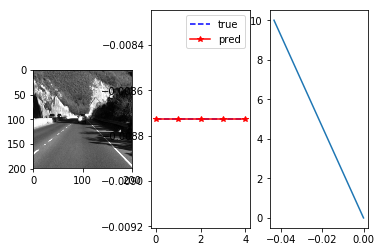

In [32]:
disp_idx = -1

# Decode pred_y to get a sequence of steering angle
pred_sequence = [one_hot_to_angle(pred_y[i][disp_idx, :], BINS_EDGE) for i in range(NUM_LABELS)]

# Interpret pred_sequence to way_pts
way_pts = np.zeros((6, 2))
for i, angle in enumerate(pred_sequence):
    next_pos = steering_angle_to_next_pos(angle)
    way_pts[i + 1, :] = way_pts[i, :] + next_pos 

# smoothen waypts (just for display purpose)
way_pts_y = savgol_filter(way_pts[:, 1], 5, 3)

# Get real value of sequence of steering angle
real_sequence = [one_hot_to_angle(test_sample_y[i][disp_idx, :], BINS_EDGE) for i in range(NUM_LABELS)]

# Display
plt.subplot(131)
plt.imshow(test_sample_X[disp_idx, :, :, 0], cmap='gray')
plt.subplot(132)
plt.plot(real_sequence, 'b--', label='true')
plt.plot(pred_sequence, 'r-*', label='pred')
plt.legend()
plt.subplot(133)
plt.plot(way_pts_y, way_pts[:, 0])
plt.show()

# TODO Generate driving video

In [33]:
from os import walk

file_name_list = []
for (dirpath, dirnames, filenames) in walk("/home/user/Bureau/Dataset/udacity/Ch2_001/center"):
    file_name_list.extend(filenames)
    break
file_name_list.sort()

In [34]:
TEST_IMG_DIR = "/home/user/Bureau/Dataset/udacity/Ch2_001/center/"
# Read all image in test folder & store in .npy file
X_test = np.zeros((len(file_name_list), 200, 200, 1))

for i, file_name in enumerate(file_name_list):
    # read image
    img = cv.imread(TEST_IMG_DIR + file_name, 0)
    # resize & reshape image
    img = np.float32(cv.resize(img, (200, 200), interpolation=cv.INTER_AREA))
    if len(img.shape) == 2:
        img = img.reshape((200, 200, 1))
    X_test[i, :, :, :] = img

In [35]:
X_test.shape

(5614, 200, 200, 1)

In [36]:
y_hat = model.predict(X_test, verbose=1)

5614/5614 [==============================] - 6s 981us/step


In [37]:
type(y_hat)

list

In [38]:
y_hat[0].shape

(5614, 114)

In [39]:
np.save("./s1p10_data/CH2_001_s1p10_y_hat.npy", y_hat)